In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [10]:
df=pd.read_csv("SpamData.csv")
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [13]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [14]:
df.isnull().sum()

Body     1
Label    0
dtype: int64

In [18]:
df=df.rename(columns={'Body':'Email','Label':'Spam'})

In [22]:
df.dtypes

Email    object
Spam      int64
dtype: object

In [26]:
df["Email"] = df["Email"].astype("str")

In [27]:
df2 = df

In [28]:
#New feature for email length
email_length = []

for email in df2['Email']:
    email_length.append(len(email))
    
df2['Email length'] = email_length

In [29]:
#New feature for number of special characters in email
special_characters = []

for email in df2['Email']:
    special_characters_counter = 0
    for char in email:
        if not char.isalnum():
            special_characters_counter+=1
    special_characters.append(special_characters_counter)
        
df2['Special characters'] = special_characters

In [30]:
#New feature for digit count in email
digits = []

for email in df2['Email']:
    digits_counter = 0
    for char in email:
        if char.isdigit():
            digits_counter+=1
    digits.append(digits_counter)
            
            
df2['Digits'] = digits

In [32]:
#New feature for number of spam trigger words present in email
spam_trigger_words = ['buy','click','get','free','order','save','limited']

trigger_words = []

for email in df2['Email']:
    trigger_words_counter = 0
    email = email.split()
    for word in email:
        if word.lower() in spam_trigger_words:
            trigger_words_counter+=1
    trigger_words.append(trigger_words_counter)
    
df2['Trigger words'] = trigger_words

In [33]:
df2.head()

,Email,Spam,Email length,Special characters,Digits,Trigger words
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,331,5,9
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,176,51,2
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,143,51,2
3,##############################################...,1,2863,1004,106,8
4,I thought you might like these:\n1) Slim Down ...,1,641,144,34,2


In [34]:
# Importing essential libraries for data preprocessing and nlp
import re
import nltk
nltk.download()
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [35]:
#dropping emails with length over 2000 and below 15

df3 = df2[(df2['Email length']<2000) & (df2['Email length']>15)]
df3.shape

(4343, 6)

In [36]:
# Data Cleaning
corpus = []
lemmatizer = WordNetLemmatizer()

for email in df3['Email']:
    # Remove subject, tabs and new lines
    removed_tabs_newline = re.sub('[\n|\t]',' ',email)
    removed_subject = re.sub('Subject:',' ',removed_tabs_newline)
    
    # Remove special characters and digits
    removed_spchar_digits = re.sub('[^a-zA-Z]',' ',removed_subject)
    
    # Convert emails into lower case
    lower_case_email = removed_spchar_digits.lower()
    
    # Tokenize the emails by words / split by words
    tokenized_email = lower_case_email.split()
    
    # Remove stopwords
    filtered_words = [word for word in tokenized_email if word not in stopwords.words('english')]
    
    # Lemmetize words
    lemmetized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    # Build corpus of emails
    email = ' '.join(lemmetized_words)
    corpus.append(email)

In [38]:
# Creating vectors using TF-IDF

tfidf = TfidfVectorizer(max_features=5000)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names_out()

# Extracting independent and dependent variables from the dataset
X = pd.DataFrame(vectors, columns=feature_names)
y = df3['Spam']

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [41]:
classifier = MultinomialNB()
classifier.fit(X_train,y_train)
print('Model score on test data:',classifier.score(X_test,y_test))

Model score on test data: 0.9800460475825019


In [42]:
cross_val_score(classifier,X_test,y_test)

array([0.95785441, 0.96934866, 0.94636015, 0.95      , 0.94230769])

In [43]:
y_predicted = classifier.predict(X_test)

In [44]:
confusion_matrix_result = confusion_matrix(y_test,y_predicted)
confusion_matrix_result

array([[928,   4],
       [ 22, 349]], dtype=int64)

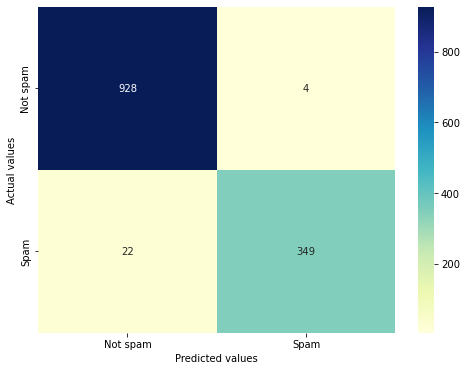

In [47]:
labels = ['Not spam','Spam']
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result,annot=True,cmap='YlGnBu',fmt='.0f',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [46]:
classification_report_result = classification_report(y_test,y_predicted)
print(classification_report_result)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       932
           1       0.99      0.94      0.96       371

    accuracy                           0.98      1303
   macro avg       0.98      0.97      0.98      1303
weighted avg       0.98      0.98      0.98      1303

